In [1]:
import numpy as np
import pandas as pd
from collections import deque
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque

# Check if GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

class DQNNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)
        self.fc4 = nn.Linear(hidden_size, action_size)
        
        self.dropout = nn.Dropout(p=0.2)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, state):
        x = self.leaky_relu(self.ln1(self.fc1(state)))
        x = self.dropout(x)
        x = self.leaky_relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.ln3(self.fc3(x)))
        x = self.dropout(x)
        q_values = self.fc4(x)
        return q_values

class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate, gamma, epsilon, min_epsilon, decay_rate):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma  # Discount rate
        self.epsilon = epsilon  # Exploration rate
        self.min_epsilon = min_epsilon
        self.epsilon_decay = decay_rate
        self.model = DQNNetwork(state_size, action_size).to(device)
        self.target_network = DQNNetwork(state_size, action_size).to(device)
        self.target_network.load_state_dict(self.model.state_dict())
        self.target_network.eval()  # Set the target network to evaluation mode
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
    
    def update_target_network(self):
        self.target_network.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)  # Send to device
        with torch.no_grad():
            action_values = self.model(state)
        return np.argmax(action_values.cpu().data.numpy())  # Move data back to CPU for numpy operations


    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)  # Send to device
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)  # Send to device

            action = torch.LongTensor([action]).to(device)
            reward = torch.FloatTensor([reward]).to(device)
            done = torch.FloatTensor([done]).to(device)

            # Forward pass
            Q_values = self.model(state)
            Q_expected = Q_values.gather(1, action.unsqueeze(1)).squeeze(1)
            Q_next = self.model(next_state).max(1)[0].detach()
            Q_target = reward + (self.gamma * Q_next * (1 - done))

            loss = nn.MSELoss()(Q_expected, Q_target)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay




# Read the CSV file
data = pd.read_csv('./tourist_problem.csv')

# Extract unique problem tags
all_tags = '; '.join(data['Problem Tags'])
tags_split = [tag.strip() for sublist in all_tags.split(';') for tag in sublist.split(',') if tag.strip()]
unique_tags = set(tags_split)
print(f"Problem Categories: {len(unique_tags)}")
# Limit to first -1 unique tags
limited_tags = list(unique_tags)
num_problem_categories = len(limited_tags)

# Split the data into training and testing sets
train_data = data.iloc[:int(0.8 * len(data))]
test_data = data.iloc[int(0.8 * len(data)):]

# Define state size based on rating index, problem categories, and duration index
rating_bins_edges = [0, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2700, 3000, 3001]
unique_durations = sorted(data['Contest Duration'].unique())
duration_bins = np.array(unique_durations + [max(unique_durations) + 1])
state_size = len(rating_bins_edges) - 1 + num_problem_categories + len(duration_bins)

# print(len(rating_bins_edges)-1, num_problem_categories, len(duration_bins))

action_values = np.arange(-200, 201, 10)  # Actions from -200 to +200 in steps of 10
action_bins = len(action_values)  # Number of actions
action_size = len(action_values)  # Define action size
action_to_index = {v: i for i, v in enumerate(action_values)}

# print("Calculated State Size:", state_size)

agent = DQNAgent(state_size, action_size, 0.001, 0.95, 1.0, 0.01, 0.995)



# Functions to process data and simulate environment
def discretize_state(state):
    rating_idx = np.digitize(state[0], bins=rating_bins_edges) - 1

    # Handle edge cases where rating_idx might be outside the expected range
    rating_idx = max(0, min(rating_idx, len(rating_bins_edges) - 2))

    rating_one_hot = [0] * (len(rating_bins_edges) - 1)
    rating_one_hot[rating_idx] = 1

    # Process problem categories
    problem_categories = [0] * num_problem_categories
    tags_in_state = [tag.strip() for sublist in state[1].split(';') for tag in sublist.split(',') if tag.strip()]
    for tag in tags_in_state:
        if tag in limited_tags:
            problem_categories[limited_tags.index(tag)] = 1

    # One-hot encode duration index
    duration_idx = np.digitize(state[2], bins=duration_bins) - 1
    duration_one_hot = [0] * len(duration_bins)
    duration_one_hot[duration_idx] = 1

    # Combine all parts of the state
    discretized_state = np.array(rating_one_hot + problem_categories + duration_one_hot)
    return discretized_state



def get_next_contest_state(data, episode):
    contest_data = data.iloc[episode]
    state = (contest_data['Old Rating'], contest_data['Problem Tags'], contest_data['Contest Duration'])
    return state

def simulate_next_contest(data, episode, action):
    current_rating = data.iloc[episode]['Old Rating']
    predicted_next_rating = current_rating + action
    actual_next_rating = data.iloc[episode]['New Rating']
    actual_rating_change = actual_next_rating - current_rating

    # print(f"Current Episode: {episode}, Current Rating: {current_rating}, Predicted Next Rating: {predicted_next_rating}, Actual Next Rating: {actual_next_rating}")

    if episode + 1 < len(data):
        next_contest_data = data.iloc[episode + 1]
        next_state = (
            next_contest_data['Old Rating'],
            next_contest_data['Problem Tags'],
            next_contest_data['Contest Duration']
        )
    else:
        next_state = (current_rating, '', 0)  # End of dataset, default state

    # print(f"Next State: {next_state}")
    return next_state, actual_rating_change

def calculate_reward(action, actual_rating_change):
    error = action - actual_rating_change
    reward = -error ** 2
    scaled_reward = reward / 1000  # Example scaling factor
    return scaled_reward

# Training Loop
epochs = 100  # Number of times to iterate over the training dataset
num_episodes = len(train_data)

max_steps_per_episode = 100  # Define maximum steps per episode if not already defined
for epoch in tqdm(range(epochs)):
    for episode in range(num_episodes):
        state = get_next_contest_state(train_data, episode)
        state = discretize_state(state)
        # print(f"Starting Episode {episode} with initial state: {state}")
        done = False
        step = 0

        while not done and step < max_steps_per_episode:
            action_index = agent.choose_action(state)
            action_value = action_values[action_index]
            # print(f"Episode {episode}, Step {step}, Current State: {state}, Action Index: {action_index}, Action Value: {action_value}")

            next_state, actual_rating_change = simulate_next_contest(train_data, episode, action_value)
            next_state = discretize_state(next_state)

            reward = calculate_reward(action_value, actual_rating_change)
            # print(f"Predicted Next State: {next_state}, Actual Rating Change: {actual_rating_change}, Reward: {reward}")

            # if np.array_equal(state, next_state):
            #     print("No state change detected.")

            state = next_state  # Update the state
            agent.remember(state, action_index, reward, next_state, done)
            step += 1

            if episode + 1 == len(train_data) or step >= max_steps_per_episode:
                done = True
                # print(f"Episode {episode} finished at step {step}")

        agent.replay(32)  # Replay with batch size 32
        agent.update_target_network()  # Update target network

        # Monitor epsilon value after decay
        # print(f"Epsilon after decay: {agent.epsilon}")
        # print("=" * 100)

Device: cuda:0
Problem Categories: 36


100%|██████████| 100/100 [47:52<00:00, 28.73s/it]


Mean Squared Error on Test Data: 11557.411764705883
Actual Rating: [3656, 3707, 3804, 3797, 3870, 3756, 3836, 3911, 3979, 3809, 3879, 3946, 3796, 3801, 3814, 3805, 3882, 3764, 3732, 3727, 3671, 3678, 3771, 3851, 3757, 3834, 3912, 3735, 3817, 3764, 3731, 3768, 3803, 3658, 3706, 3486, 3635, 3588, 3662, 3622, 3611, 3664, 3755, 3767, 3726, 3727, 3817, 3751, 3775, 3557, 3585]
Predicted Rating: [3919, 3696, 3797, 3734, 3837, 3720, 3786, 3926, 4011, 3969, 3689, 3979, 3896, 3836, 3891, 3854, 3845, 3972, 3864, 3772, 3657, 3601, 3778, 3811, 3951, 3607, 3924, 4002, 3775, 3747, 3754, 3831, 3698, 3653, 3648, 3636, 3586, 3735, 3678, 3592, 3552, 3601, 3524, 3845, 3787, 3826, 3817, 3917, 3681, 3655, 3597]


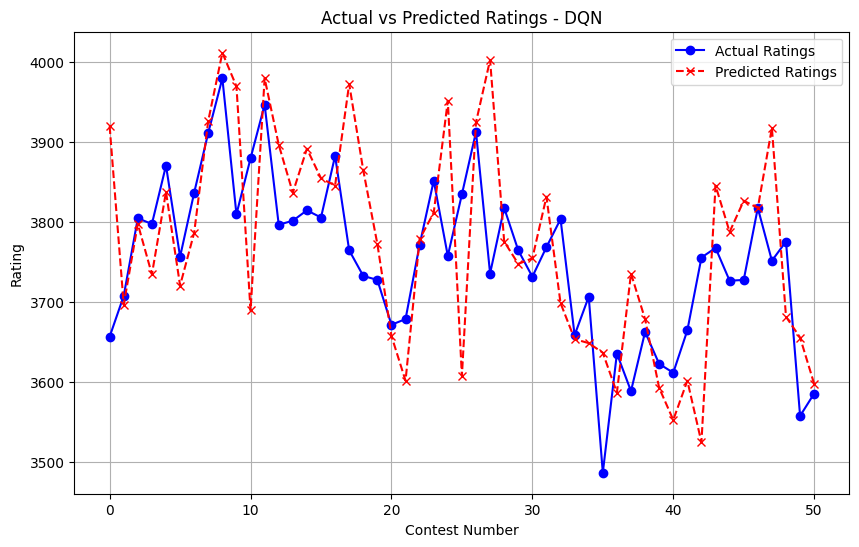

In [ ]:
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
agent.model.eval()

# Check if GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming test_data is a DataFrame similar to train_data
def evaluate_model(agent, test_data, action_values):
    test_predictions = []
    test_actuals = []
    episodes = []

    for episode in range(len(test_data)):
        episodes.append(episode)
        state = get_next_contest_state(test_data, episode)
        # Ensure that state is based only on information up to the contest, not after
        state = discretize_state(state)
        
        # Convert state to PyTorch tensor and send to the device
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = agent.model(state_tensor)
        action_index = q_values.max(1)[1].item()  # Get the index of the max q-value
        action_value = action_values[action_index]

        # Apply the predicted rating change to the 'Old Rating'
        predicted_rating_change = action_value
        actual_next_rating = test_data.iloc[episode]['New Rating']  # This is the true rating after the contest
        predicted_next_rating = test_data.iloc[episode]['Old Rating'] + predicted_rating_change  # Prediction

        test_predictions.append(predicted_next_rating)
        test_actuals.append(actual_next_rating)

    mse = np.mean((np.array(test_predictions) - np.array(test_actuals)) ** 2)
    print(f"Mean Squared Error on Test Data: {mse}")

    print(f"Actual Rating: {test_actuals}")
    print(f"Predicted Rating: {test_predictions}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, test_actuals, label='Actual Ratings', color='blue', marker='o')
    plt.plot(episodes, test_predictions, label='Predicted Ratings', color='red', linestyle='dashed', marker='x')
    plt.title('Actual vs Predicted Ratings - DQN')
    plt.xlabel('Contest Number')
    plt.ylabel('Rating')
    plt.legend()
    plt.grid(True)
    # Save the figure
    plt.savefig('actual_vs_predicted_ratings_DQN.png', dpi=1200)  # Adjust the file name and dpi as needed
    plt.savefig('actual_vs_predicted_ratings_DQN.pdf', dpi=1200)  # Adjust the file name and dpi as needed
    plt.show()

# Call the evaluate function
evaluate_model(agent, test_data, action_values)